In [1]:
import os
import pandas as pd
import torch
import json
import torch.nn as nn

import math
from typing import Tuple

import torch
from torch import nn, Tensor
import torch.nn.functional as F
from torch.nn import Transformer
from torch.nn import TransformerEncoder, TransformerEncoderLayer
from torch.utils.data import dataset

from sklearn.manifold import TSNE
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
import torch.optim as optim
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
from sklearn.utils import shuffle

In [2]:
price_folder = "data/stocknet-dataset/price/raw"
tweet_folder = "data/stocknet-dataset/tweet/preprocessed"

symbols = np.sort(os.listdir(tweet_folder))
print(symbols, len(symbols))

['AAPL' 'ABB' 'ABBV' 'AEP' 'AGFS' 'AMGN' 'AMZN' 'BA' 'BABA' 'BAC' 'BBL'
 'BCH' 'BHP' 'BP' 'BRK-A' 'BSAC' 'BUD' 'C' 'CAT' 'CELG' 'CHL' 'CHTR'
 'CMCSA' 'CODI' 'CSCO' 'CVX' 'D' 'DHR' 'DIS' 'DUK' 'EXC' 'FB' 'GD' 'GE'
 'GOOG' 'HD' 'HON' 'HRG' 'HSBC' 'IEP' 'INTC' 'JNJ' 'JPM' 'KO' 'LMT' 'MA'
 'MCD' 'MDT' 'MMM' 'MO' 'MRK' 'MSFT' 'NEE' 'NGG' 'NVS' 'ORCL' 'PCG' 'PCLN'
 'PEP' 'PFE' 'PG' 'PICO' 'PM' 'PPL' 'PTR' 'RDS-B' 'REX' 'SLB' 'SNP' 'SNY'
 'SO' 'SPLP' 'SRE' 'T' 'TM' 'TOT' 'TSM' 'UL' 'UN' 'UNH' 'UPS' 'UTX' 'V'
 'VZ' 'WFC' 'WMT' 'XOM'] 87


# RUN BELOW CELL ONLY ONCE

In [ ]:
for symbol in tqdm(symbols):
    print(symbol)
    tweet_dates = np.array(os.listdir(tweet_folder + "/" + symbol))
    start_date = tweet_dates[0]
    end_date = tweet_dates[-1]

    df = pd.read_csv(price_folder + "/" + symbol + ".csv")
    std = np.nanstd(df[df["Date"] >= start_date]["Open"].values)
    mean = np.nanmean(df[df["Date"] >= start_date]["Open"].values)
    print(std, mean)
    
    input_df = df[(df["Date"] >= start_date) & (df["Date"] <= end_date)]
    price_dates = input_df["Date"].values
    target_df = df[(df["Date"] > end_date)]

    tweet_data = dict()
    idx = 0
    tweet_data[price_dates[idx]] = list()
    for date in tqdm(tweet_dates):
        if date < price_dates[idx]:
            continue
        elif date >= price_dates[idx] and ((idx < len(price_dates) - 1) and (date < price_dates[idx + 1])):
            with open(tweet_folder + "/" + symbol + "/" + date, "r") as file:
                tweet_data[price_dates[idx]] += [(date, " ".join(eval(tweet[:-1])['text'])) for tweet in file.readlines()]
        else:
            while (idx < len(price_dates) - 1) and (date >= price_dates[idx + 1]):
                idx += 1
                tweet_data[price_dates[idx]] = list()

            with open(tweet_folder + "/" + symbol + "/" + date, "r") as file:
                tweet_data[price_dates[idx]] += [(date, " ".join(eval(tweet[:-1])['text'])) for tweet in file.readlines()]

    input_data = dict()
    for date in price_dates:
        input_data[date] = {"price": input_df[input_df["Date"] == date]["Open"].values[0],
                            "tweets": tweet_data[date]}

    target_data = dict()
    for date in target_df["Date"].values:
        target_data[date] = {"price": target_df[target_df["Date"] == date]["Open"].values[0]}

    out_data = {"input": input_data, "target": target_data}
    with open(f"data/processed_data3/{symbol}.json", 'w') as fp:
        json.dump(out_data, fp)

### Utils

In [3]:
def getDataBySymbol(symbol):
    with open(f"data/processed_data/{symbol}.json", 'r') as fp:
        data = json.load(fp)
    return data

In [4]:
def printProcessedData(symbol):
    data = getDataBySymbol(symbol)
    
    print("#" * 47)
    print("#" * 20 + " INPUT " + "#" * 20)
    print("#" * 47)
    
    for date in data["input"]:
        print(date)
        print("\t", data["input"][date]["price"])
        print("\t Tweets:")
        for tweet in data["input"][date]["tweets"]:
            print("\t\t", tweet[0], tweet[1])
    
    print("#" * 47)
    print("#" * 20 + " TARGET " + "#" * 20)
    print("#" * 47)
    
    for date in data["target"]:
        print(date, data["target"][date]["price"])

In [5]:
def visualizeProcessedData(symbol):
    data = getDataBySymbol(symbol)
    
    pi = data["input"]
    x_pi = [x for x in pi]
    y_pi = [pi[x]["price"] for x in pi]
    y2_pi = [len(pi[x]["tweets"]) for x in pi]
    
    fig = plt.figure(figsize=(20, 10))
    
    ax1 = fig.add_subplot(111)
    ax1.scatter(x_pi, y_pi, label="price")
    ax1.set_ylabel("Price")
    
    ax2 = ax1.twinx()
    ax2.bar(x_pi, y2_pi, color='green', alpha=0.5, label="# of tweets")
    ax2.set_ylabel("# of Tweets")
    
    ax1.set_xticks(x_pi[::10])
    ax1.set_xticklabels(x_pi[::10], rotation=90)
    ax1.set_xlabel("Date")
    
    plt.legend()
    plt.title("Inputs")
    plt.show()
    
    pt = data["target"]
    x_pt = [x for x in pt]
    y_pt = [pt[x]["price"] for x in pt]
    
    plt.figure(figsize=(20, 10))
    plt.scatter(x_pt, y_pt)
    plt.xlabel("Date")
    plt.xticks(x_pt[::10], rotation=90)
    plt.ylabel("Price")
    plt.title("Targets")
    plt.show()

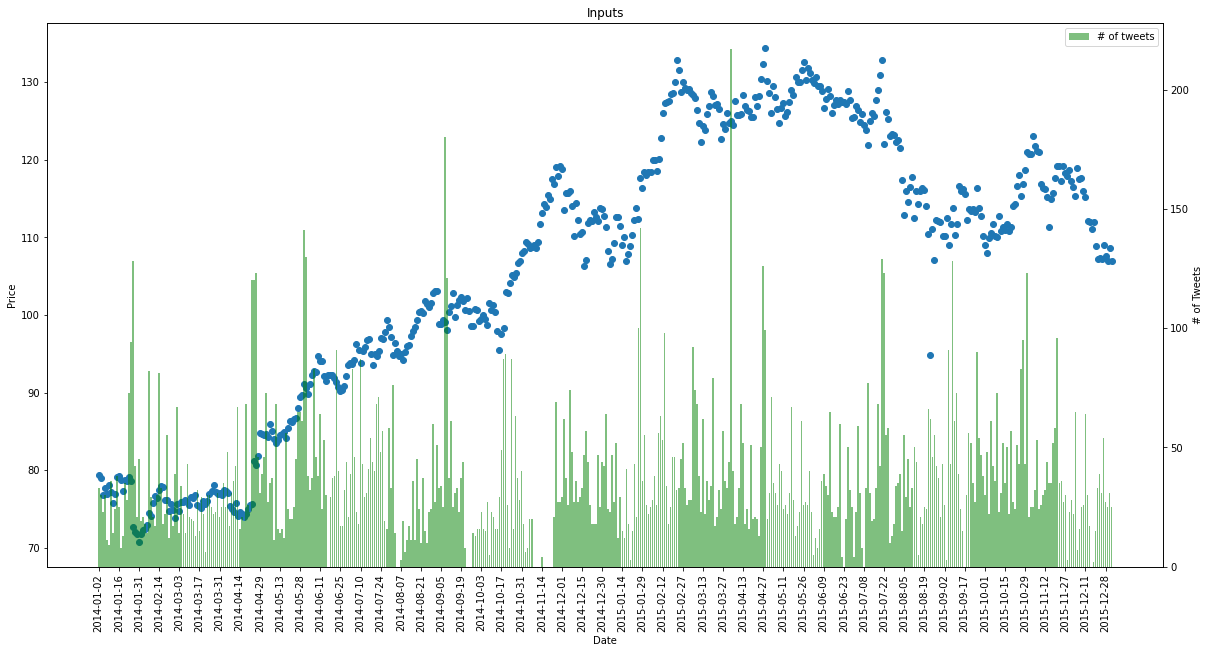

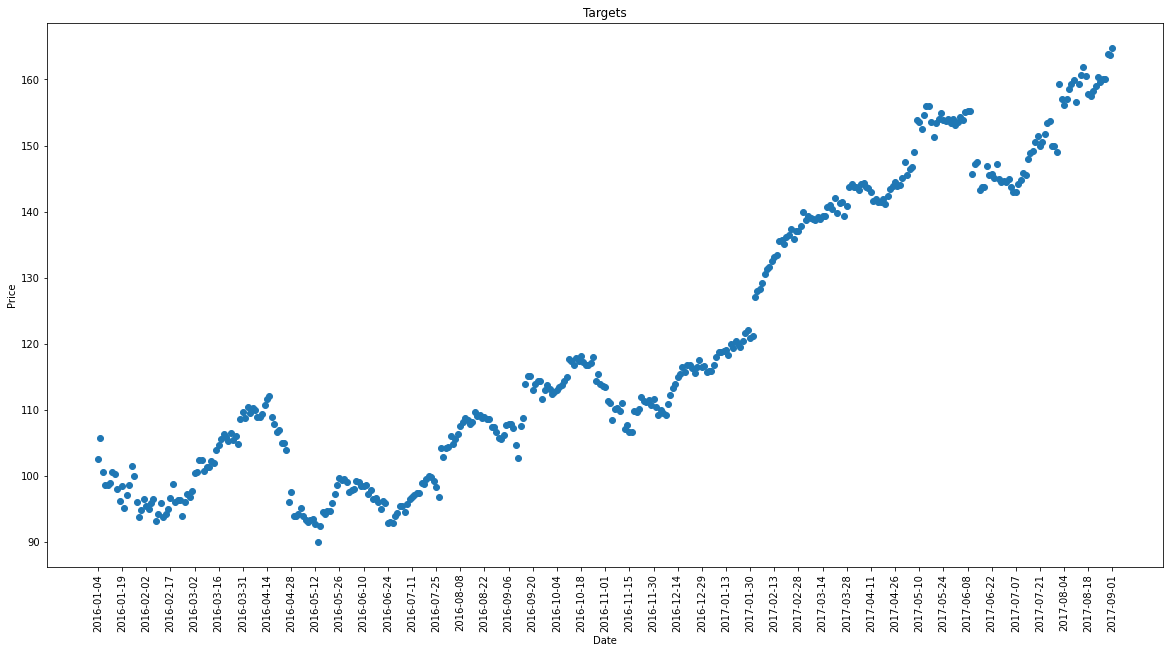

In [6]:
visualizeProcessedData("AAPL")